# TODO:
- finish shap algorithm
- update all cells with current ds
- finish drug dataset

# Diabetes
by Kenan Sooklall

Diabetes is a chronic (long-lasting) health condition that affects how your body turns food into energy.

Most of the food you eat is broken down into sugar (also called glucose) and released into your bloodstream. When your blood sugar goes up, it signals your pancreas to release insulin. Insulin acts like a key to let the blood sugar into your body’s cells for use as energy.

Source: [Centers for Disease Control and Preventation](https://www.cdc.gov/diabetes/basics/diabetes.html)

In [234]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
%matplotlib inline

Dropping
- A lot of missing values
    - weight 
    - payer code
    - medical_specialty
- Only one value
    - examide, citoglipton have 
- Conflict
    - race
- Duplicated patient_nbr

In [157]:
#df = pd.read_csv('abhishek_diabetes.csv', index_col=[0]).query('Diabetes_012 != "1"').rename(columns={'Diabetes_012': 'label'})
#df['label'] = df['label'].map({0: 0, 2: 1})
drop_cols = ['examide', 'citoglipton', 'encounter_id','weight', 'payer_code', 'medical_specialty', 'race']
df = pd.read_csv('dataset_diabetes/diabetic_data.csv').drop(drop_cols, axis=1).replace('?', np.nan).drop_duplicates(subset=['patient_nbr'])

In [158]:
print(df.shape)
df.head()

(71518, 43)


,patient_nbr,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,8222157,Female,[0-10),6,25,1,1,41,0,1,...,No,No,No,No,No,No,No,No,No,NO
1,55629189,Female,[10-20),1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,86047875,Female,[20-30),1,1,7,2,11,5,13,...,No,No,No,No,No,No,No,No,Yes,NO
3,82442376,Male,[30-40),1,1,7,2,44,1,16,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,42519267,Male,[40-50),1,1,7,1,51,0,8,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [159]:
df.columns

Index(['patient_nbr', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

The data set contains 22 columns and 253680 rows
- Encounter ID Unique identifier of an encounter
- Patient number Unique identifier of a patient
- Race Values: Caucasian, Asian, African American, Hispanic, and other
- Gender Values: male, female, and unknown/invalid
- Age Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100)
- Weight Weight in pounds
- Admission type Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available
- Discharge disposition Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available
- Admission source Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital
- Time in hospital Integer number of days between admission and discharge
- Payer code Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay Medical
- Medical specialty Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon
- Number of lab procedures Number of lab tests performed during the encounter
- Number of procedures Numeric Number of procedures (other than lab tests) performed during the encounter
- Number of medications Number of distinct generic names administered during the encounter
- Number of outpatient visits Number of outpatient visits of the patient in the year preceding the encounter
- Number of emergency visits Number of emergency visits of the patient in the year preceding the encounter
- Number of inpatient visits Number of inpatient visits of the patient in the year preceding the encounter
- Diagnosis 1 The primary diagnosis (coded as first three digits of ICD9); 848 distinct values
- Diagnosis 2 Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values
- Diagnosis 3 Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
- Number of diagnoses Number of diagnoses entered to the system 0%
- Glucose serum test result Indicates the range of the result or if the test was not taken. Values: “>200,” “>300,” “normal,” and “none” if not measured
- A1c test result Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than 7%, and “none” if not measured.
- Change of medications Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”

- Diabetes medications Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”
24 features for medications For the generic names: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, glimepiride- pioglitazone, metformin-rosiglitazone, and metformin- pioglitazone, the feature indicates whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not change, and “no” if the drug was not prescribed
- Readmitted Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days, “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission

source: https://archive-beta.ics.uci.edu/ml/datasets/diabetes+130+us+hospitals+for+years+1999+2008

###  Exploratory Data Analysis

Very lucky to find a dataset with no missing values and no duplicated rows

In [160]:
df.isna().sum()

patient_nbr                    0
gender                         0
age                            0
admission_type_id              0
discharge_disposition_id       0
admission_source_id            0
time_in_hospital               0
num_lab_procedures             0
num_procedures                 0
num_medications                0
number_outpatient              0
number_emergency               0
number_inpatient               0
diag_1                        11
diag_2                       294
diag_3                      1225
number_diagnoses               0
max_glu_serum                  0
A1Cresult                      0
metformin                      0
repaglinide                    0
nateglinide                    0
chlorpropamide                 0
glimepiride                    0
acetohexamide                  0
glipizide                      0
glyburide                      0
tolbutamide                    0
pioglitazone                   0
rosiglitazone                  0
acarbose  

In [47]:
for i in df.columns:
    print(i)
    print(df[i].value_counts())

patient_nbr
85331970     1
6157332      1
56339487     1
2432565      1
91200537     1
            ..
50921172     1
64490004     1
100143639    1
94923288     1
35488413     1
Name: patient_nbr, Length: 71518, dtype: int64
gender
Female             38025
Male               33490
Unknown/Invalid        3
Name: gender, dtype: int64
age
[70-80)     18210
[60-70)     15960
[50-60)     12466
[80-90)     11589
[40-50)      6878
[30-40)      2699
[90-100)     1900
[20-30)      1127
[10-20)       535
[0-10)        154
Name: age, dtype: int64
admission_type_id
1    36490
3    13917
2    13028
6     4588
5     3174
8      291
7       21
4        9
Name: admission_type_id, dtype: int64
discharge_disposition_id
1     44317
3      8784
6      8289
18     2474
2      1539
22     1410
11     1077
5       913
25      778
4       541
7       409
23      260
13      243
14      218
28       90
8        73
15       40
24       25
9         9
17        8
19        6
10        6
16        3
27        3
12

we can see the data are all on very different scales, which is to be expected. An initial point of concern is  SkinThichkness of 0mm, however that could be more of a percision issue. Another column of concern is BMI, BloodPressure and Glucose, it can't be 0. The min age being greater than 0 is expected and all other values look normal

In [48]:
metrics = ['mean', 'median', 'std']
df.groupby(['readmitted']).agg({"number_diagnoses": metrics,
                            "num_medications": metrics,
                               'num_procedures': metrics,
                               'time_in_hospital': metrics
                               })

number_diagnoses                  num_medications                   \
                       mean median       std            mean median       std   
readmitted                                                                      
<30                7.513745      8  1.845945       16.620213     15  8.320525   
>30                7.485791      8  1.873747       15.892941     15  7.768834   
NO                 7.082238      8  2.058517       15.473816     14  8.565825   

           num_procedures                  time_in_hospital                   
                     mean median       std             mean median       std  
readmitted                                                                    
<30              1.422692      1  1.729095         4.797394      4  3.058465  
>30              1.355126      1  1.739747         4.419604      4  2.969866  
NO               1.470769      1  1.773368         4.147214      3  2.910694

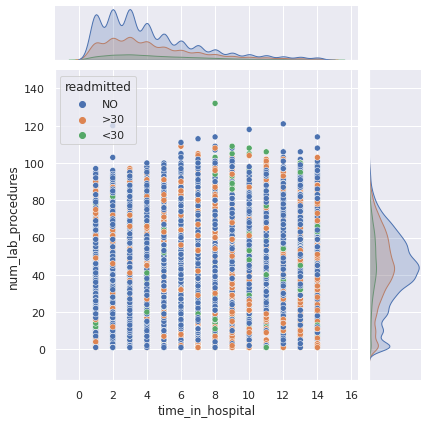

In [11]:
sns.jointplot(x='time_in_hospital' ,y='num_lab_procedures' ,hue='readmitted', data=df)

<AxesSubplot:xlabel='readmitted', ylabel='count'>

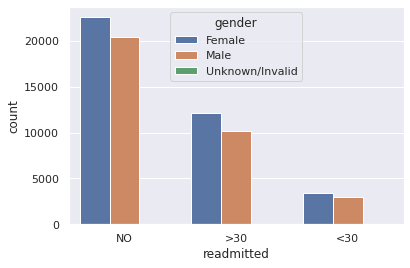

In [12]:
sns.countplot(x='readmitted', data=df, hue='gender')

gender seems to be mostly independant if someone will be remitted

<AxesSubplot:xlabel='readmitted', ylabel='count'>

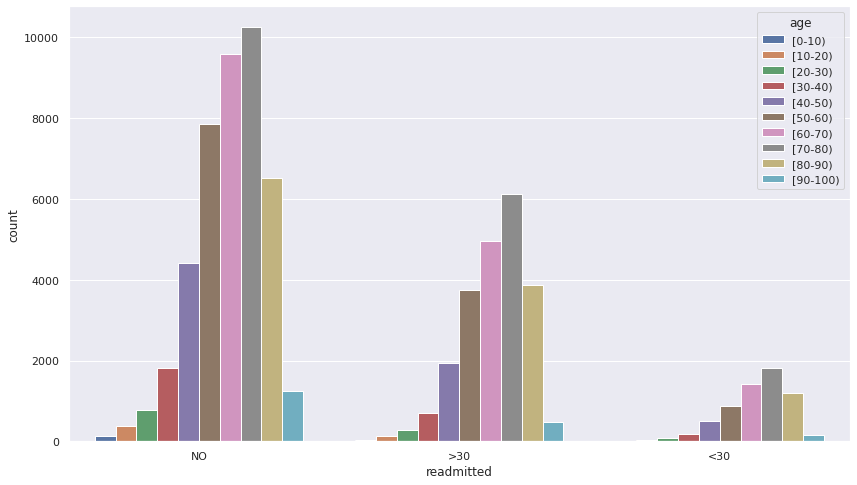

In [13]:
plt.figure(figsize=(14, 8))
sns.countplot(x='readmitted', data=df, hue='age')

The older portion of the population is the majority for all ranges of readmitted

<AxesSubplot:xlabel='readmitted', ylabel='count'>

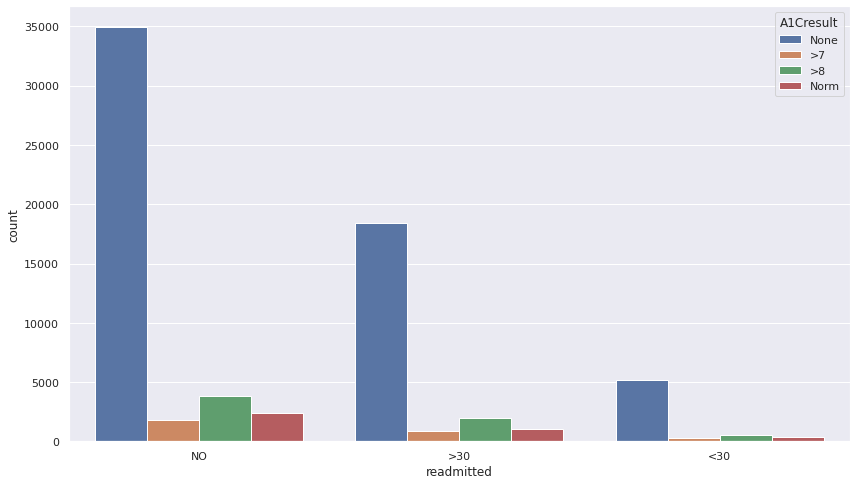

In [14]:
plt.figure(figsize=(14, 8))
sns.countplot(x='readmitted', data=df, hue='A1Cresult')

<AxesSubplot:xlabel='age', ylabel='time_in_hospital'>

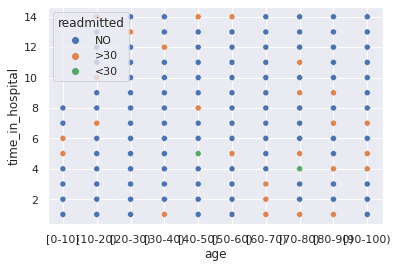

In [15]:
sns.scatterplot(x='age', y='time_in_hospital', data=df, hue='readmitted')

Quantify categorical data

quantify variables
- age - take the median values
- readmitted - 0: NO 1: other

In [161]:
df['age'] = df['age'].map(lambda x: sum([int(i) for i in x[1:-1].split('-')]) // 2)
df['readmitted'] = df['readmitted'].map({'NO': 0, '>30': 1, '<30': 1})
cdf = df.select_dtypes('O')
ndf = df.select_dtypes(np.number)

le = LabelEncoder()

for i in cdf.columns:
    cdf[i] = le.fit_transform(cdf[i])

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Map ids

In [18]:
def map_diagnosis(data, cols):
    for col in cols:
        data.loc[(data[col].str.contains("V")) | (data[col].str.contains("E")), col] = -1
        data[col] = data[col].astype(np.float16)

    for col in cols:
        data["temp_diag"] = np.nan
        data.loc[(data[col]>=390) & (data[col]<=459) | (data[col]==785), "temp_diag"] = "Circulatory"
        data.loc[(data[col]>=460) & (data[col]<=519) | (data[col]==786), "temp_diag"] = "Respiratory"
        data.loc[(data[col]>=520) & (data[col]<=579) | (data[col]==787), "temp_diag"] = "Digestive"
        data.loc[(data[col]>=250) & (data[col]<251), "temp_diag"] = "Diabetes"
        data.loc[(data[col]>=800) & (data[col]<=999), "temp_diag"] = "Injury"
        data.loc[(data[col]>=710) & (data[col]<=739), "temp_diag"] = "Muscoloskeletal"
        data.loc[(data[col]>=580) & (data[col]<=629) | (data[col] == 788), "temp_diag"] = "Genitourinary"
        data.loc[(data[col]>=140) & (data[col]<=239), "temp_diag"] = "Neoplasms"

        data["temp_diag"] = data["temp_diag"].fillna("Other")
        data[col] = data["temp_diag"]
        data = data.drop("temp_diag", axis=1)

    return data

In [19]:
df = map_diagnosis(df, ["diag_1","diag_2","diag_3"])

In [20]:
df.filter(like='diag')

,diag_1,diag_2,diag_3,number_diagnoses
0,Diabetes,Other,Other,1
1,Other,Diabetes,Other,9
2,Other,Diabetes,Other,6
3,Other,Diabetes,Circulatory,7
4,Neoplasms,Neoplasms,Diabetes,5
...,...,...,...,...
101754,Digestive,Digestive,Diabetes,9
101755,Genitourinary,Genitourinary,Respiratory,9
101756,Injury,Genitourinary,Circulatory,9
101758,Other,Other,Other,9


In [21]:
drug_cols = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
             'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
             'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
             'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 
             'metformin-rosiglitazone', 'metformin-pioglitazone']

<AxesSubplot:ylabel='readmitted'>

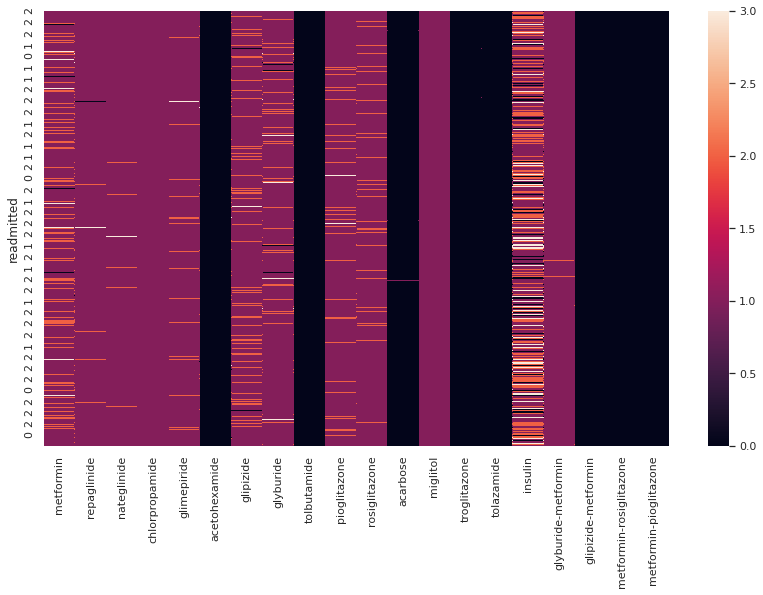

In [31]:
plt.figure(figsize=(14, 8))
sns.heatmap(cdf[drug_cols + ['readmitted']].set_index('readmitted'))

In [124]:
df['number_emergency'].skew()

21.149176235228644

In [125]:
np.log(df['number_emergency']+1).skew()

4.2635780247027695

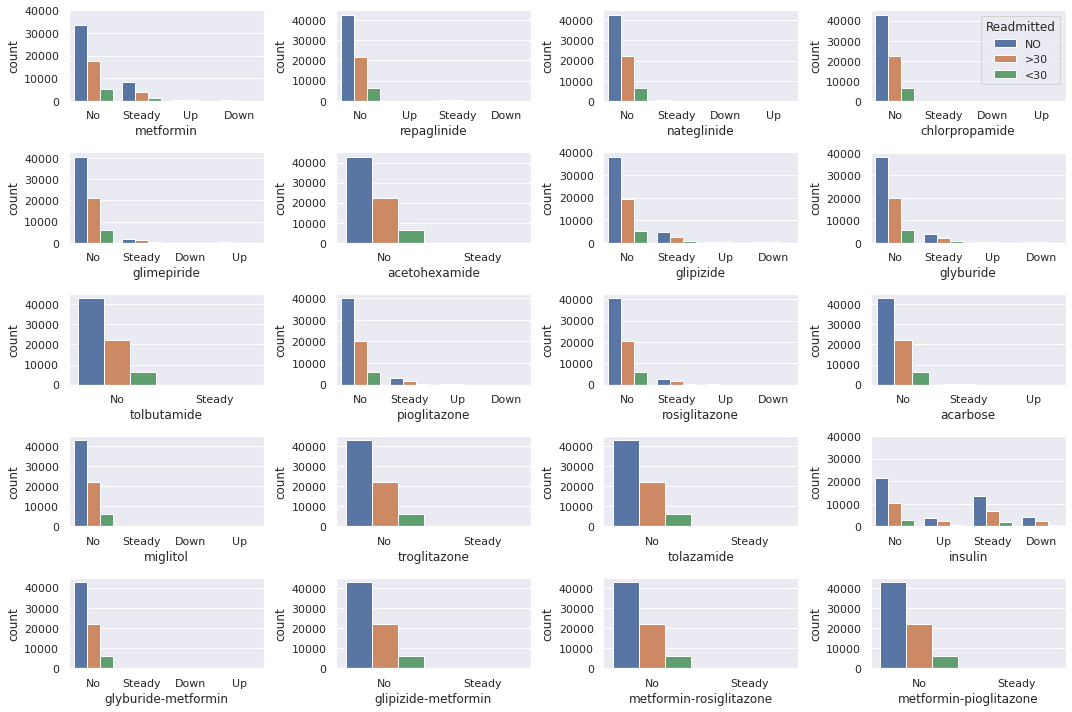

In [113]:
fig, axs = plt.subplots(5, 4, figsize = (15, 10))
for idx, i in enumerate(axs.flatten()):
    drug = drug_cols[idx]
    sns.countplot(data=df[drug_cols + ['readmitted']], x=drug, hue='readmitted', ax=i)#.set(title=drug)
    i.set_yticks([0, 1e4,2e4,3e4,4e4])
    if idx != 3:
        i.legend([],[], frameon=False)
    else:
        i.legend(title="Readmitted", loc='upper right')
    
#handles, labels = axs[-1][-1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper right')
plt.tight_layout()

In [116]:
df['readmitted'].value_counts()

NO     42985
>30    22240
<30     6293
Name: readmitted, dtype: int64

In [115]:
df['metformin-pioglitazone'].value_counts()

No        71517
Steady        1
Name: metformin-pioglitazone, dtype: int64

In [176]:
features = ['readmitted', 'gender', 'age', 'time_in_hospital']#, 'num_lab_procedures', 'num_procedures', 'num_medications','number_outpatient', 'A1Cresult']
num_cols = ['age', 'time_in_hospital']

In [193]:
(df['age'] - df['age'].min())/(df['age'].max() - df['age'].min())

0         0.000000
1         0.111111
2         0.222222
3         0.333333
4         0.444444
            ...   
101754    0.777778
101755    0.444444
101756    0.666667
101758    0.888889
101765    0.777778
Name: age, Length: 71518, dtype: float64

### Logistic Regression
This is a classification problem so LogisticRegression  is a good starting model

In [195]:
diab_df = pd.concat([cdf, ndf], axis=1)[features]

In [196]:
scaler = StandardScaler()
diab_df.loc[:, num_cols] = scaler.fit_transform(df[num_cols])

In [197]:
diab_df.head()

,readmitted,gender,age,time_in_hospital
0,0,0,-3.795970,-1.115266
1,1,0,-3.170108,-0.437113
2,0,0,-2.544246,-0.776190
3,0,1,-1.918384,-0.776190
4,0,1,-1.292522,-1.115266


In [198]:
seed = 42
train_cols = diab_df.drop(['readmitted'], axis=1).columns
X_train, X_test, y_train, y_test = train_test_split(diab_df.drop(['readmitted'], axis=1), diab_df['readmitted'])

I fine tune the model using sklearn grid search cross validation on 10 splits. The grid is the search space

In [199]:
lg_model = LogisticRegression(random_state=seed, penalty='l2').fit(X_train, y_train)
#stats = cross_validate(model, X, y_train, cv=10, scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [204]:
y_pred = lg_model.predict(X_test)
logistic_report = classification_report(y_test, y_pred, target_names=['no', 'yes'])
print(logistic_report)

              precision    recall  f1-score   support

          no       0.60      0.99      0.74     10648
         yes       0.40      0.01      0.02      7232

    accuracy                           0.59     17880
   macro avg       0.50      0.50      0.38     17880
weighted avg       0.52      0.59      0.45     17880



In [206]:
print(f'Training score: {lg_model.score(X_train, y_train)}\nTesting score: {lg_model.score(X_test, y_test)}')

Training score: 0.6006189641671948
Testing score: 0.5936241610738255


In [207]:
y_prob = lg_model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_prob)

0.5564274282573319

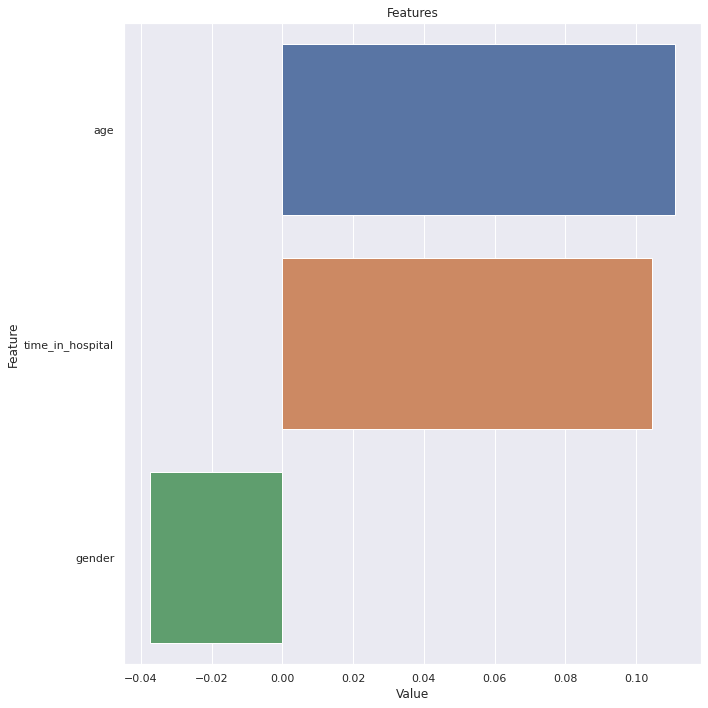

In [212]:
feature_imp = pd.DataFrame({'Value': lg_model.coef_[0], 'Feature': X_train.columns})
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:8])
plt.title('Features')
plt.tight_layout()
plt.show()

In [255]:
k_explainer = shap.KernelExplainer(lg_model.predict_proba, X_test)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

Using 17880 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [213]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)

RandomForestClassifier()

In [215]:
rf_model.score(X_train, y_train)

0.6051679779260972

In [217]:
rf_model.score(X_test,y_test)

0.5919463087248322

In [218]:
rf_model.feature_importances_.shape

(3,)

/home/kenan/anaconda3/envs/pyt/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

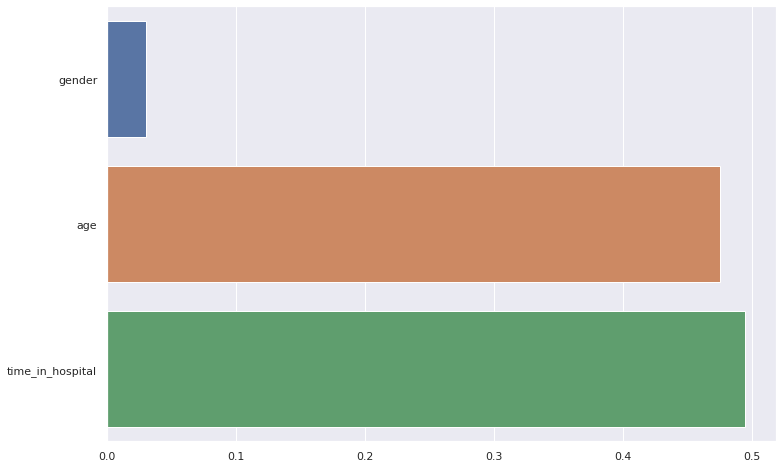

In [220]:
plt.figure(figsize=(12,8))
sns.barplot(sorted(rf_model.feature_importances_),train_cols)

In [254]:
row_to_show = 5
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


print(rf_model.predict_proba(data_for_prediction_array))
explainer = shap.TreeExplainer(rf_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

[[0.55541909 0.44458091]]


In [251]:
k_explainer = shap.KernelExplainer(rf_model.predict_proba, X_test)
k_shap_values = k_explainer.shap_values(data_for_prediction)
shap.force_plot(k_explainer.expected_value[1], k_shap_values[1], data_for_prediction)

Using 17880 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/5 [00:00<?, ?it/s]

In [244]:
clf = AdaBoostClassifier(n_estimators=250)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
logistic_report = classification_report(y_test, y_pred, target_names=['no', 'yes'])
print(logistic_report)

              precision    recall  f1-score   support

          no       0.60      1.00      0.75     10648
         yes       0.00      0.00      0.00      7232

    accuracy                           0.60     17880
   macro avg       0.30      0.50      0.37     17880
weighted avg       0.35      0.60      0.44     17880



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [241]:
gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=.01, max_depth=5, random_state=0)
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)
logistic_report = classification_report(y_test, y_pred, target_names=['no', 'yes'])
print(logistic_report)

              precision    recall  f1-score   support

          no       0.60      0.99      0.75     10648
         yes       0.40      0.01      0.01      7232

    accuracy                           0.59     17880
   macro avg       0.50      0.50      0.38     17880
weighted avg       0.52      0.59      0.45     17880



### Multi-layer Perceptron

In [221]:
import torch
import torch.nn as nn

In [222]:
LEARNING_RATE = 1e-1
DENSE = 32
EPOCHS = 100

In [223]:
torch.manual_seed(seed)
device = torch.device('cpu')

model = nn.Sequential(
    nn.Linear(X.shape[1], DENSE),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(DENSE),
    nn.Linear(DENSE, DENSE//2),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(DENSE//2),
    nn.Linear(DENSE//2, 1)
    )

model.float().to(device)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU(inplace=True)
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=16, out_features=1, bias=True)
)

In [224]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1, steps_per_epoch=10, epochs=EPOCHS)

In [226]:
X_tensor = torch.tensor(X_train.values).float().to(device)
y_tensor = torch.tensor(y_train.values.reshape(y_train.shape[0], 1)).float().to(device)

In [227]:
best_acc = 0
best_model = None
history = []

for i in range(EPOCHS):
    y_pred = model(X_tensor)
    loss = criterion(y_pred.float(), y_tensor)
    acc = ((y_pred > 0.5).int() == y_tensor).sum() / X_tensor.shape[0]
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    history.append({'epoch': i, 'loss': loss.item(), 'acc': acc.item()})
    lr = optimizer.param_groups[0]['lr']
    
    if i % (EPOCHS/10) == 0:
        print('Epoch: {} \tloss: {:.3f} \tacc: {:.3f} \tlr: {:.4f}'.format(i, loss.item(), acc.item(), lr))
        
    if acc > best_acc:
        #print('[+] Saving best')
        best_acc = acc
        best_model = model

RuntimeError: mat1 and mat2 shapes cannot be multiplied (53638x3 and 2x32)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,8))
train_df = pd.DataFrame(history)
train_df.plot(x='epoch', y='loss', title='Training loss', ax=ax[0])
train_df.plot(x='epoch', y='acc', title='Training Accuracy', ax=ax[1])
plt.tight_layout()

In [ ]:
y_prob = best_model(torch.tensor(Xt_std).float().to(device))
roc_auc_score(y_test, y_prob.detach().numpy())

In [ ]:
y_pred = (y_prob > 0.5).int().detach().numpy()
mlp_report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

### Comparing models

In [ ]:
print('Logistic Regression')
print('-' * 60)
print(logistic_report + '\n')
print('Multi-layer Perceptron')
print('-' * 60)
print(mlp_report)


Over all Logistic regression provided a better model with a higher weighted avg F1-Score and all combinations of precision and recall. Both models suffer from similar problems of low precision and negative examples and  low recall on positive examples. The logistic regression also wins in the fact of how easy it is to train compare to the MLP. The MLP required a lot of tuning and computing power while logistic regression ran quickly.

In [ ]:
Xt_tensor = torch.tensor(X_test.values).float().to(device)

In [ ]:
explainer = shap.DeepExplainer(model, data=X_tensor[:1000])
shap_values = explainer.shap_values(Xt_tensor[:100])

In [ ]:
explainer.expected_value

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], Xt_tensor)

# Conclusions 

In the United States, 88 million adults, more than 1 in 3 have prediabetes. What’s more, more than 84% of them don’t know they have it. The analysis done in this report is just a tiny fraction of the enormous work put into this field. The models trained here can do better with more data points and more features. However with the limited data the models created performed well.